Downloading the dataset


In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip

--2024-04-28 13:37:11--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.168.155, 52.219.47.239, 3.5.135.17, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.168.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 936875950 (893M) [application/zip]
Saving to: ‘2011_09_26_drive_0106_sync.zip’

2011_09_26_drive_01 100%[===================>] 893.47M  20.3MB/s    in 45s     

2024-04-28 13:37:57 (19.7 MB/s) - ‘2011_09_26_drive_0106_sync.zip’ saved [936875950/936875950]



In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip

--2024-04-28 13:37:57--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.247, 52.219.169.141, 52.219.170.65, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2024-04-28 13:37:58 (74.5 MB/s) - ‘2011_09_26_calib.zip’ saved [4068/4068]



In [ ]:
!jar xf 2011_09_26_drive_0106_sync.zip

In [ ]:
!jar xf 2011_09_26_calib.zip

In [ ]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)


Lidar Data in Binary Format

In [ ]:
DATA_PATH = r'2011_09_26/2011_09_26_drive_0106_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))



Left Image


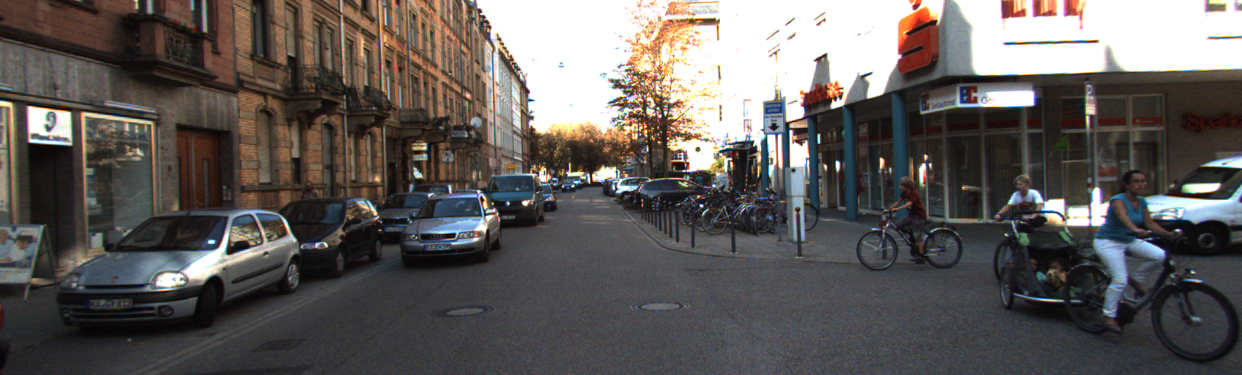

Right Image


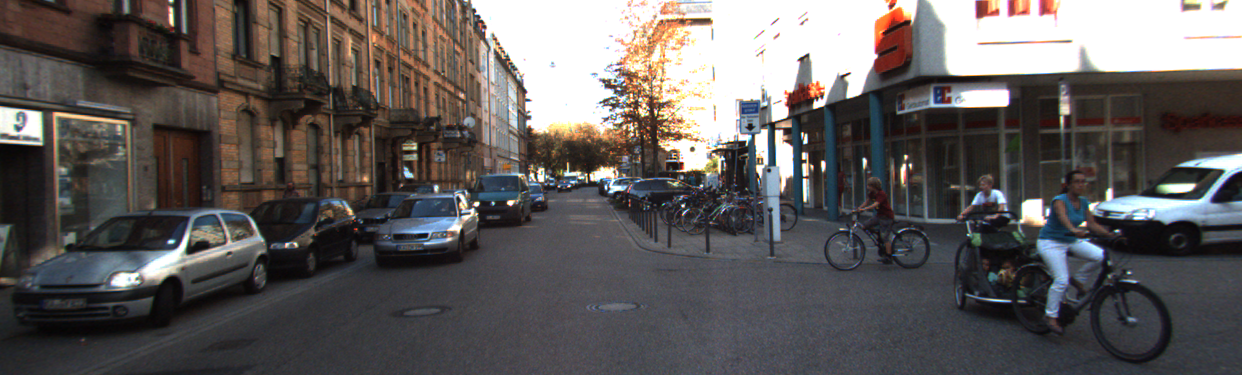

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import os


index = 3

left_image = cv2.imread(left_image_paths[index])
right_image = cv2.imread(right_image_paths[index])

print("Left Image")
cv2_imshow(left_image)
print("Right Image")
cv2_imshow(right_image)


Camera Calibration Data for the right and left camera

In [ ]:
with open('2011_09_26/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

Rotation and Translation Matrices for lidar data to be converted to frame of camera

In [ ]:
with open(r'2011_09_26/calib_velo_to_cam.txt', 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

T_cam_velo

array([[ 7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
       [ 1.480249e-02,  7.280733e-04, -9.998902e-01, -7.631618e-02],
       [ 9.998621e-01,  7.523790e-03,  1.480755e-02, -2.717806e-01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

Matrix to convert frame from velo (LiDAR) to left color camera

In [ ]:
T_velo_cam = P_left @ R_left_rect @ T_cam_velo
T_velo_cam

array([[ 6.13040929e+02, -7.18575854e+02, -2.95002805e+00,
        -1.24072003e+02],
       [ 1.82759005e+02,  1.22395125e+01, -7.18988552e+02,
        -1.01607812e+02],
       [ 9.99893357e-01,  4.69739411e-03,  1.38291498e-02,
        -2.69119537e-01]])

Function to read LiDAR bin file and returns homogeneous (x,y,z,1) LiDAR points

In [ ]:
from sklearn import linear_model

def bin2h_velo(lidar_bin, remove_plane=True):

    scan_data = np.fromfile(lidar_bin, dtype=np.float32).reshape((-1,4))

    # get x,y,z LiDAR points (x, y, z) --> (front, left, up)
    velo_points = scan_data[:, 0:3]

    # delete negative liDAR points
    velo_points = np.delete(velo_points, np.where(velo_points[3, :] < 0), axis=1)

    # use ransac to remove ground plane
    if remove_plane:
            ransac = linear_model.RANSACRegressor(
                                          linear_model.LinearRegression(),
                                          residual_threshold=0.1,
                                          max_trials=5000
                                          )

            X = velo_points[:, :2]
            y = velo_points[:, -1]
            ransac.fit(X, y)

            mask = ransac.inlier_mask_
            velo_points = velo_points[~mask]

    velo_points = np.insert(velo_points, 3, 1, axis=1).T

    return velo_points


Function to map velo points (LiDAR) to camera (u,v,z) space

In [ ]:
def velo2camera(velo_points, image=None, remove_outliers=True):

    velo_camera =  T_velo_cam @ velo_points

    # delete negative camera points ??
    velo_camera  = np.delete(velo_camera , np.where(velo_camera [2,:] < 0)[0], axis=1)

    # get camera coordinates u,v,z
    velo_camera[:2] /= velo_camera[2, :]

    # remove outliers (points outside of the image frame)
    if remove_outliers:
        u, v, z = velo_camera
        img_h, img_w, _ = image.shape
        u_out = np.logical_or(u < 0, u > img_w)
        v_out = np.logical_or(v < 0, v > img_h)
        outlier = np.logical_or(u_out, v_out)
        velo_camera = np.delete(velo_camera, np.where(outlier), axis=1)

    return velo_camera

Function to project LiDAR point cloud onto the image coordinate frame

In [ ]:
def project_velo2cam(lidar_bin, image, remove_plane=True):

    # get homogeneous LiDAR points from binn file
    velo_points = bin2h_velo(lidar_bin, remove_plane)

    # get camera (u, v, z) coordinates
    velo_camera = velo2camera(velo_points, image, remove_outliers=True)

    return velo_camera

In [ ]:
index = 3

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]


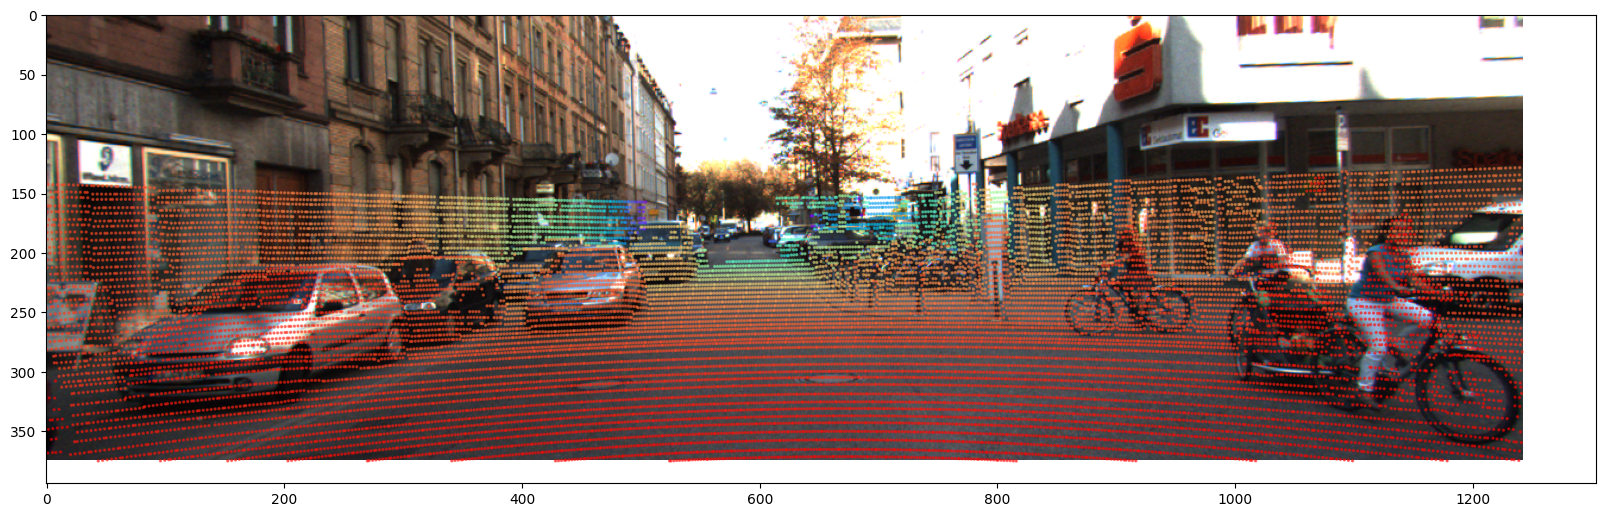

In [ ]:
(u, v, z) = project_velo2cam(lidar_bin, left_image, remove_plane=False)

# plot points over iamge
plt.imshow(left_image)
plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2);

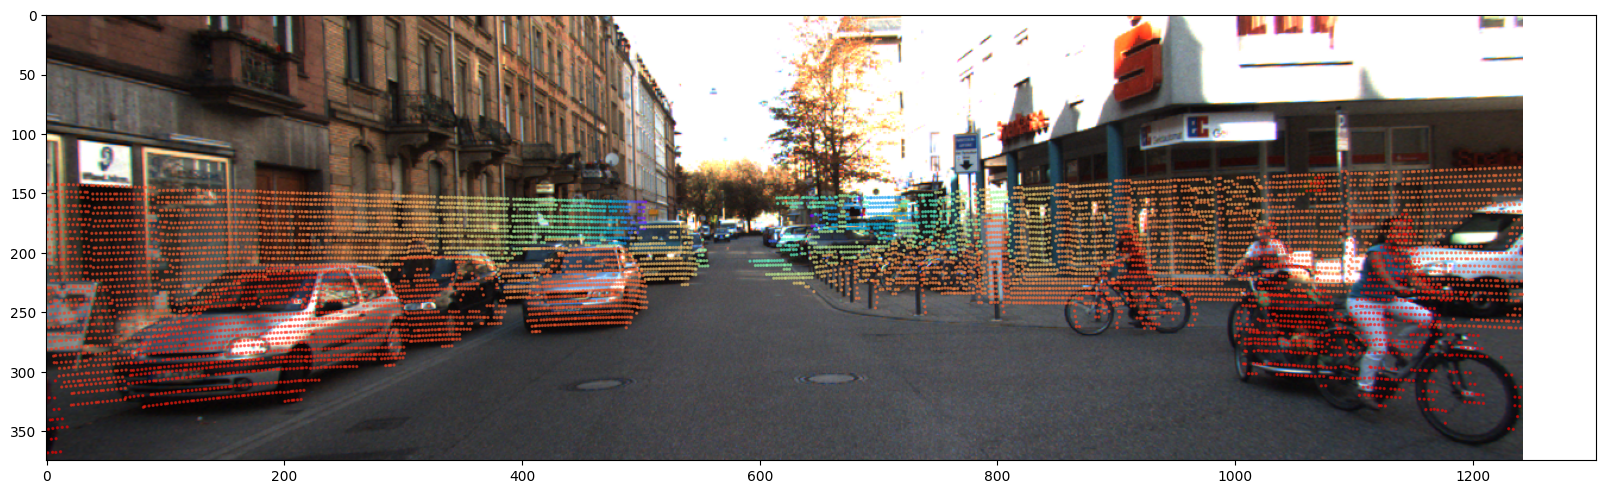

In [ ]:
# plot points over image
(u, v, z) = project_velo2cam(lidar_bin, left_image)
plt.imshow(left_image)
plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2);

Get Object Detection Pipeline

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16567, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 16567 (delta 23), reused 32 (delta 13), pack-reused 16522
Receiving objects: 100% (16567/16567), 15.07 MiB | 18.66 MiB/s, done.
Resolving deltas: 100% (11376/11376), done.


In [ ]:
!pip install -r yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.1/752.1 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_

In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

In [ ]:
# set confidence and IOU thresholds
model.conf = 0.25
model.iou = 0.25

Function to calculate distance measurements for each detected object in the image from the camera

In [ ]:
import torch
import numpy as np
import cv2

def get_distances(image, velo_camera, bboxes, draw=True):

    u, v, z = velo_camera

    bboxes_cpu = bboxes.cpu().numpy()
    bboxes_out = np.zeros((bboxes_cpu.shape[0], bboxes_cpu.shape[1] + 3))
    bboxes_out[:, :bboxes_cpu.shape[1]] = bboxes_cpu

    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).cpu().numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).cpu().numpy()

        # get center location of the image
        x_center = (pt1[1] + pt2[1]) / 2
        y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u)) - np.array([[x_center, y_center]]).T)

        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        velo_location = np.array([v[min_loc], u[min_loc], velo_depth])

        # add velo (u, v, z) to bboxes
        bboxes_out[i, -3:] = velo_location

        # draw depth on image at center of each bounding box
        if draw:
            object_center = (np.round(y_center).astype(int), np.round(x_center).astype(int))
            cv2.putText(image,
                        '{0:.2f} m'.format(velo_depth),
                        object_center,
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (255, 0, 0), 2, cv2.LINE_AA)

    return image, bboxes_out


Obtains detections depth estimates for all objects in the image using the lidar point closest to the center of the bounding box

In [ ]:
def get_depth_detections(left_image, lidar_bin, draw_boxes=True,
                         draw_depth=True):

    detections = model(left_image)

    if draw_boxes:
        detections.show()

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0]

    # get LiDAR points and transform them to image/camera space
    velo_camera = project_velo2cam(lidar_bin, left_image)


    # get distance measurements for image
    left_image, bboxes_out = get_distances(left_image,
                                           velo_camera,
                                           bboxes,
                                           draw=draw_depth)


    return left_image, bboxes_out, velo_camera

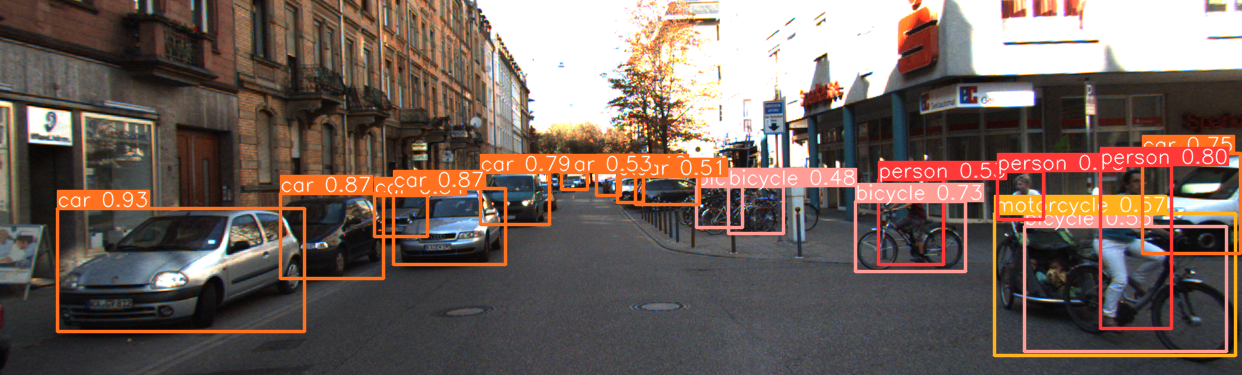

In [ ]:
index = 3

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

left_image, bboxes_out, velo_camera = get_depth_detections(left_image, lidar_bin,
                                                           draw_boxes=True,
                                                           draw_depth=True)

In [ ]:
from matplotlib import cm

# get color map function
rainbow_r = cm.get_cmap('rainbow_r', lut=100)
get_color = lambda z : [255*val for val in rainbow_r(int(z.round()))[:3]]

def draw_velo_on_image(velo_camera, velo_image, color_map=get_color):

    # unpack LiDAR points
    u, v, z = velo_camera

    # draw LiDAR point cloud on blank image
    for i in range(len(u)):
        cv2.circle(velo_image, (int(u[i]), int(v[i])), 1,
                  color_map(z[i]), -1);

    return velo_image


In [ ]:
# velo_image = np.zeros_like(left_image)
# velo_image = draw_velo_on_image(velo_camera, velo_image)

# stacked = np.vstack((left_image, velo_image))



The distance on the image indicates the distance of the detected object from the camera


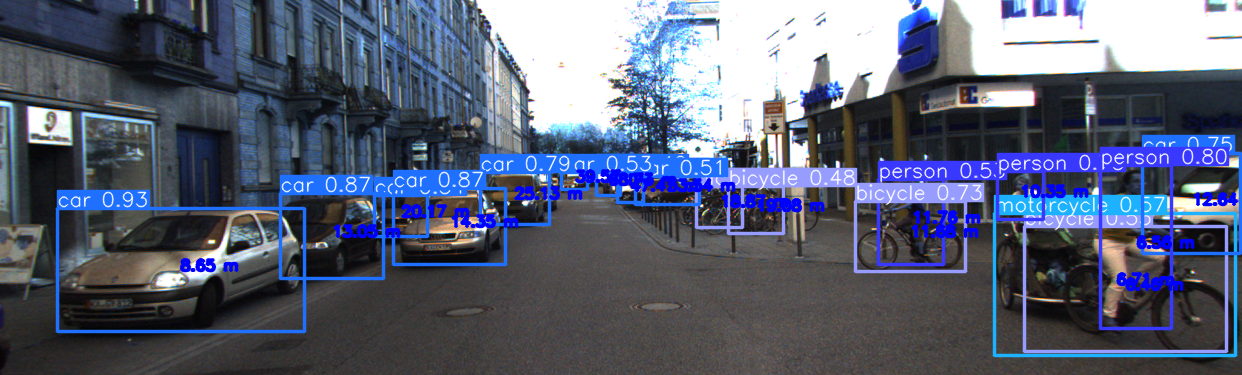

In [ ]:
from google.colab.patches import cv2_imshow


# Create an empty image with the same dimensions as left_image
velo_image = np.zeros_like(left_image)

# Draw LiDAR points on the empty image
velo_image = draw_velo_on_image(velo_camera, velo_image)

# Stack left_image with velo_image
stacked = np.vstack((left_image, velo_image))

# Display the stacked image
print("The distance on the image indicates the distance of the detected object from the camera")
cv2_imshow(left_image)


In [ ]:
def image_clusters_from_velo(velo_points, labels, image):

    cam_clusters = {}
    for label in np.unique(labels):

        # convert from velo to camera
        velo_cam = velo2camera(velo_points[:, labels == label], image)

        # append cluster label and cluster to clusters
        if velo_cam.shape[1] > 0:
            cam_clusters.update({label : velo_cam})

    return cam_clusters

In [ ]:
def draw_clusters_on_image(image, cluster_dict, draw_centroids=False):

    pastel = cm.get_cmap('Pastel2', lut=50)
    get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

    for label, cluster in cluster_dict.items():
        for (u, v, z) in cluster.T:
            cv2.circle(image, (int(u), int(v)), 1,
                       get_pastel(label), -1);

        if draw_centroids:
            centroid = np.mean(cluster, axis=1)
            cv2.circle(image, (int(centroid[0]), int(centroid[1])), 5,
                       get_pastel(label), -1);

    return image


In [ ]:
velo_points = bin2h_velo(lidar_bin, remove_plane=True)

Obtaining cluster using DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=30)
dbscan.fit(velo_points[:3, :].T)

DBSCAN(min_samples=30)

In [ ]:
labels = dbscan.labels_
cam_clusters = image_clusters_from_velo(velo_points, labels, left_image)

<ipython-input-58-e2e6f7354474>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pastel = cm.get_cmap('Pastel2', lut=50)


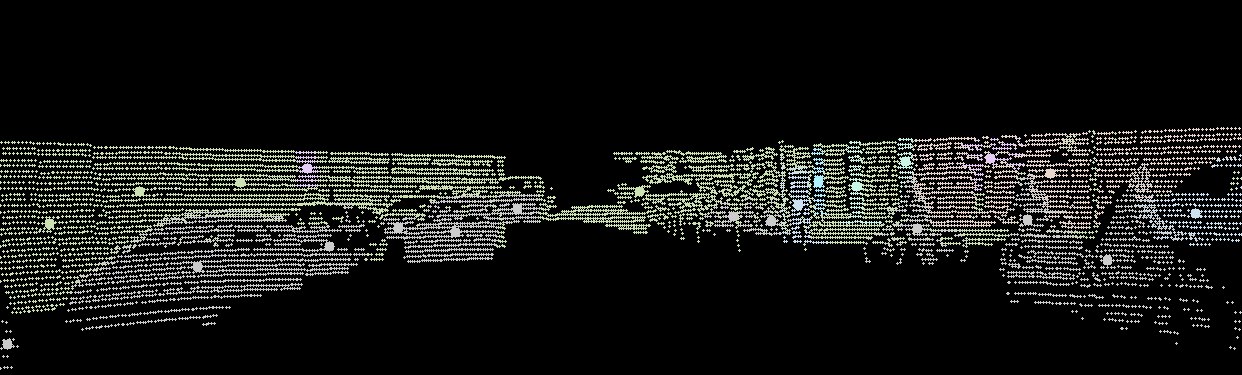

In [ ]:
new_image = np.zeros_like(left_image)
new_image = draw_clusters_on_image(new_image, cam_clusters, draw_centroids=True)
cv2_imshow(new_image)

In [ ]:
from sklearn.cluster import DBSCAN

def get_clusters(velo_points):
    dbscan = DBSCAN(eps=0.5, min_samples=30)
    dbscan.fit(velo_points[:3, :].T)

    labels = dbscan.labels_

    return dbscan, labels

In [ ]:
def get_likely_clusters(cluster_dict, object_centers, min_thresh=50, thresh=75):

    new_clusters = {}
    noise_cluster = cluster_dict[-1]

    labels = sorted(cluster_dict)

    for label in labels:
        cluster = cluster_dict[label]

        if cluster.shape[1] > min_thresh \
           and cluster.shape[1] < noise_cluster.shape[1] //2:

            # ensure centroid has correct order
            centroid = np.mean(cluster, axis=1)[[1, 0, 2]]

            # check if any objects are detected
            if len(object_centers) > 0:
                delta = np.linalg.norm(centroid - object_centers, axis=1)
                min_loc = np.argmin(delta)

                if delta[min_loc] < thresh:
                    new_clusters.update({label : cluster})

            else:
                new_clusters.update({label : cluster})

    return new_clusters

In [ ]:
def get_3d_bboxes(cluster_dict, labels, velo_points):
    camera_box_point_list = []

    for c_label, cluster in cluster_dict.items():

        velo_cluster = velo_points[:3, labels == c_label]

        (x_min, y_min, z_min) = velo_cluster.min(axis=1)
        (x_max, y_max, z_max) = velo_cluster.max(axis=1)

        # now get points to define 3d bounding box
        # box_points = np.array([[x_max, y_max, z_max]]) * arr
        # just manually do this for now
        box_points = np.array([
            [x_max, y_max, z_max, 1],
            [x_max, y_max, z_min, 1],
            [x_max, y_min, z_max, 1],
            [x_max, y_min, z_min, 1],
            [x_min, y_max, z_max, 1],
            [x_min, y_max, z_min, 1],
            [x_min, y_min, z_max, 1],
            [x_min, y_min, z_min, 1]
        ])

        # convert these box points to image space
        camera_box_points = T_velo_cam @ box_points.T
        camera_box_points[:2] /= camera_box_points[2, :]

        camera_box_points = camera_box_points.round().T.astype(int)

        # append to list
        camera_box_point_list.append(camera_box_points)

    return camera_box_point_list

In [ ]:
pastel = cm.get_cmap('Pastel2', lut=50)
get_pastel = lambda z : [255*val for val in pastel(z)[:3]]

def draw_3d_boxes(image, camera_box_points):
    for i, box_pts in enumerate(camera_box_points):
        [A, B, C, D, E, F, G, H] = box_pts[:, :2]
        color = get_pastel(i)

        # draw rear box (X-axis is forward for LiDAR)
        cv2.line(image, A, B, color, 2)
        cv2.line(image, B, D, color, 2)
        cv2.line(image, A, C, color, 2)
        cv2.line(image, D, C, color, 2)

        # draw front box
        cv2.line(image, G, E, color, 2)
        cv2.line(image, H, F, color, 2)
        cv2.line(image, G, H, color, 2)
        cv2.line(image, E, F, color, 2)

        # draw sides
        cv2.line(image, E, A, color, 2)
        cv2.line(image, G, C, color, 2)
        cv2.line(image, F, B, color, 2)
        cv2.line(image, H, D, color, 2)

    return image

<ipython-input-66-f3f4a742d5dd>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pastel = cm.get_cmap('Pastel2', lut=50)


In [ ]:
index = 20

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

velo_points = bin2h_velo(lidar_bin, remove_plane=True) # possibly RANSAC the walls too

In [ ]:
def main_pipeline(left_image, lidar_bin, velo_points):
    # get object detections
    left_image, bboxes_out, velo_camera = get_depth_detections(left_image,
                                                           lidar_bin,
                                                           draw_boxes=False,
                                                           draw_depth=False)

    # perform clustering in LiDAR space
    dbscan, labels = get_clusters(velo_points)


    # get clusters in image space
    cam_clusters = image_clusters_from_velo(velo_points, labels, left_image)

    # get object centers in camera (u, v, z) coordinates
    object_centers = bboxes_out[:, 6:]

    # remove small and large clusters also remove cluster far away from detected objects
    cam_clusters = get_likely_clusters(cam_clusters, object_centers, min_thresh=50, thresh=75)

    # get 3D bbox points in camera space from clusters
    camera_box_points = get_3d_bboxes(cam_clusters, labels, velo_points)

    # draw 3D bounding boxes on the image
    left_image = draw_3d_boxes(left_image, camera_box_points)

    return left_image, cam_clusters



<ipython-input-58-e2e6f7354474>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pastel = cm.get_cmap('Pastel2', lut=50)


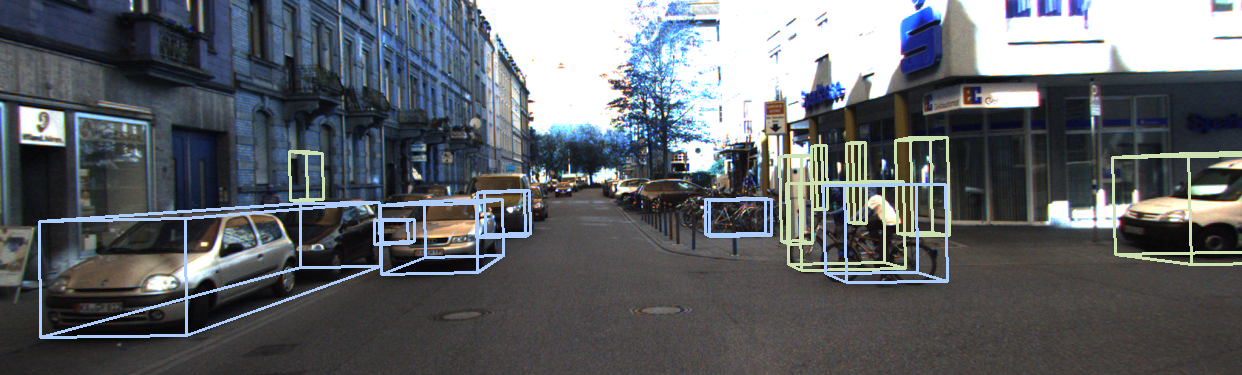

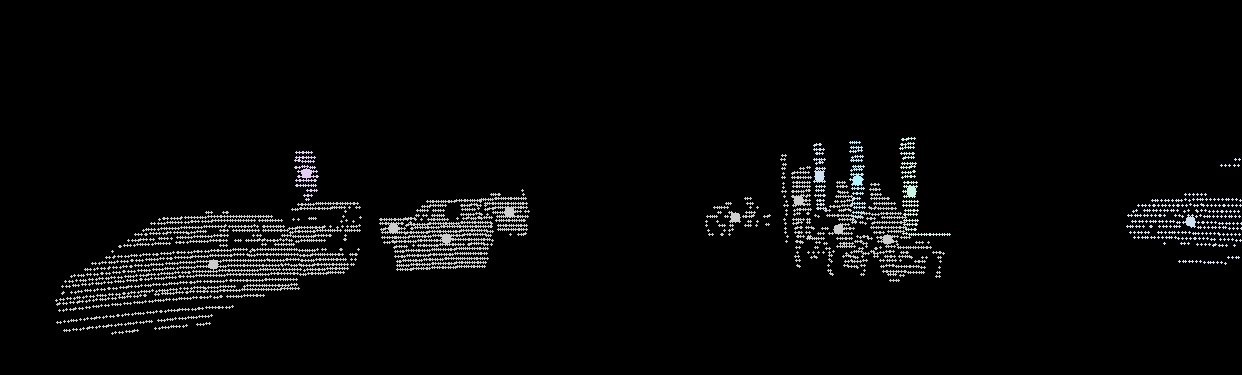

In [ ]:
# run pipeline
left_image, cam_clusters = main_pipeline(left_image, lidar_bin, velo_points)

# draw projected clusters on new image
cluster_image = np.zeros_like(left_image)
cluster_image = draw_clusters_on_image(cluster_image, cam_clusters, draw_centroids=True)

stacked = np.vstack((left_image, cluster_image))


cv2_imshow(left_image)

cv2_imshow(cluster_image)

In [ ]:
result_video = []
print("Video will be saved in the file named - Final_Object_Detection_Video")
for idx in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    lidar_bin = bin_paths[idx]

    # read in raw velo points
    velo_points = bin2h_velo(lidar_bin, remove_plane=True) # possibly RANSAC the walls too

    # run pipeline
    left_image, cam_clusters = main_pipeline(left_image, lidar_bin, velo_points)

    # draw projected clusters on new image
    cluster_image = np.zeros_like(left_image)
    cluster_image = draw_clusters_on_image(cluster_image, cam_clusters, draw_centroids=True)

    # stack frames
    stacked = np.vstack((left_image, cluster_image))

    # add to result video
    result_video.append(stacked)

# get width and height for video frames
h, w, _ = stacked.shape

out = cv2.VideoWriter('Final_Object_Detection_Video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()



Video will be saved in the file named - Final_Object_Detection_Video


<ipython-input-58-e2e6f7354474>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pastel = cm.get_cmap('Pastel2', lut=50)
<ipython-input-58-e2e6f7354474>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pastel = cm.get_cmap('Pastel2', lut=50)
<ipython-input-58-e2e6f7354474>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pastel = cm.get_cmap('Pastel2', lut=50)
<ipython-input-58-e2e6f7354474>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.